In [61]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [64]:
#Create Validation Set
df_valid = pd.read_csv('test.csv')
df_gender = pd.read_csv('gender_submission.csv')

df_valid = pd.merge(df_valid, df_gender, on='PassengerId')
df_valid.dropna(subset=['Survived'], inplace=True)
df_valid.dropna(subset=['Fare'], inplace=True)

df_valid.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [65]:
def manual_preprocess_df(df):
    df = df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis = 1)
    df['Embarked'] = df['Embarked'].map({
        'C' : 0,
        'Q' : 1,
        'S' : 2
    })
    df['Sex'] = df['Sex'].map({
        'male' : 0,
        'female' : 1
    })
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df.dropna(subset=['Embarked'], inplace=True)
    return df

In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [67]:
df_train = manual_preprocess_df(df_train)
df_valid = manual_preprocess_df(df_valid)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


In [68]:
#Label - Data Splits
def label_data_split(df):
    y = df['Survived']
    x = df.loc[:, df.columns != 'Survived']
    return (x,y)

In [69]:
#Train - Test Split & Shuffling
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

df_train = shuffle(df_train)

(labels, targets) = label_data_split(df_train)

x_train, x_test, y_train, y_test = train_test_split(labels, targets, test_size=0.33)

In [70]:
#Scaler
from sklearn.preprocessing import StandardScaler

D = 7

dataScaler = StandardScaler()

x_train = dataScaler.fit_transform(x_train)
x_test = dataScaler.transform(x_test)

In [71]:
#Build Model With TF Keras Functional API
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.models import Model

i = Input(shape=(D,1))
x = LSTM(32, return_sequences=True, activation=LeakyReLU(alpha=0.2))(i)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = LSTM(128, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [72]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(
        learning_rate=0.0011
    ),
    metrics = ['accuracy']
)

In [73]:
#Early Stop For Val_Accuracy
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=15)

In [74]:
r = model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs = 150,
    callbacks=[early_stop]
)

Epoch 1/150
19/19 [==============================] - 6s 59ms/step - loss: 0.6855 - accuracy: 0.5882 - val_loss: 0.6601 - val_accuracy: 0.6565
Epoch 2/150
19/19 [==============================] - 0s 24ms/step - loss: 0.6725 - accuracy: 0.5983 - val_loss: 0.6430 - val_accuracy: 0.6565
Epoch 3/150
19/19 [==============================] - 0s 25ms/step - loss: 0.6710 - accuracy: 0.5983 - val_loss: 0.6400 - val_accuracy: 0.6565
Epoch 4/150
19/19 [==============================] - 0s 24ms/step - loss: 0.6610 - accuracy: 0.5966 - val_loss: 0.6244 - val_accuracy: 0.6565
Epoch 5/150
19/19 [==============================] - 1s 28ms/step - loss: 0.6425 - accuracy: 0.5866 - val_loss: 0.5773 - val_accuracy: 0.6633
Epoch 6/150
19/19 [==============================] - 0s 24ms/step - loss: 0.6233 - accuracy: 0.6269 - val_loss: 0.5482 - val_accuracy: 0.6633
Epoch 7/150
19/19 [==============================] - 0s 24ms/step - loss: 0.6046 - accuracy: 0.6538 - val_loss: 0.5431 - val_accuracy: 0.6973
Epoch 

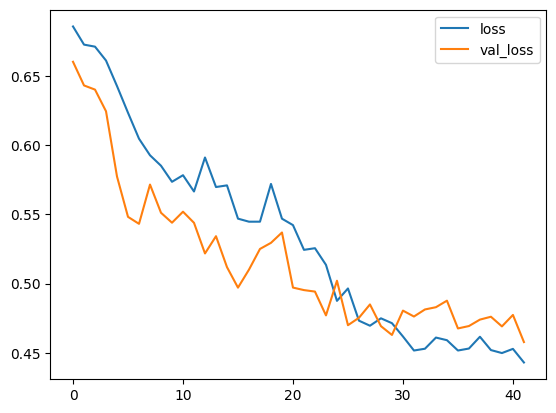

In [75]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')

plt.legend()

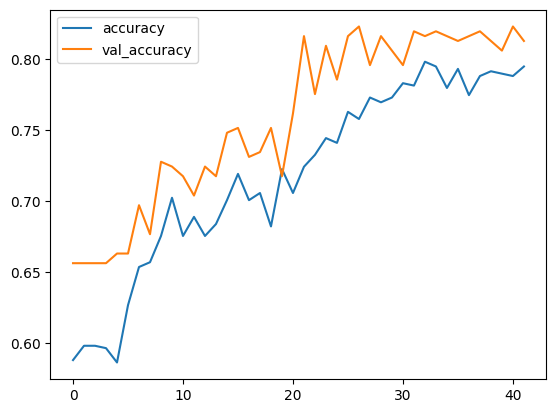

In [76]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')

plt.legend()

In [77]:
#Evaluate Split Train Data
split_evals = model.evaluate(
    x_test,
    y_test
)

10/10 [==============================] - 0s 7ms/step - loss: 0.4578 - accuracy: 0.8129


In [78]:
#Evaluate with merged submission sample
(x_valid, y_valid) = label_data_split(df_valid)

x_valid = dataScaler.transform(x_valid)

merged_evals = model.evaluate(
    x_valid,
    y_valid
)

14/14 [==============================] - 0s 7ms/step - loss: 0.3861 - accuracy: 0.8201


<BarContainer object of 4 artists>

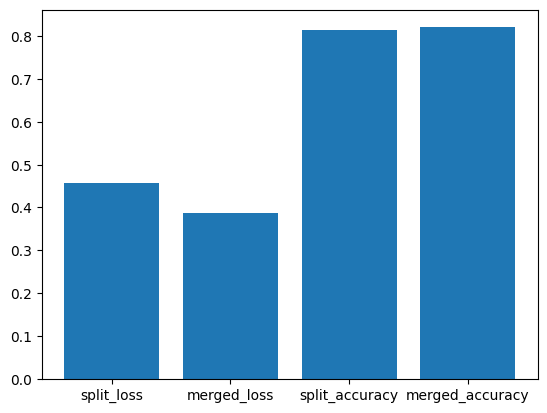

In [79]:
labels = ["split_loss", "merged_loss", "split_accuracy", "merged_accuracy"]
values = [split_evals[0], merged_evals[0], split_evals[1], merged_evals[1]]

plt.bar(labels, values)

In [80]:
prediction_df = pd.read_csv('test.csv')

prediction_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# prompt: save model to json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)



In [89]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [82]:
!pip install tensorflowjs==3.8.0

In [90]:
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model

# Load your existing Keras model
model_ = load_model('my_model.h5')

# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(model_, "content")